<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Physics_Particle_Segmentation_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Particle segmentation

In this notebook, we attempt to train neural networks for particle segmentation

We use a slimmed down dataset of a public dataset from the [Deep Learn Physics Challenge](http://deeplearnphysics.org/DataChallenge/). The dataset is a set of images of five types particles (electron, gamma ray, muon, charged pion, and proton) projected in the xy-plane. For semantic segmentation, the images are labelled with three classes: background, EM-shower particles, and track particles (i.e. not EM-shower).


In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization, SeparableConv2D, UpSampling2D


# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from os.path import join


# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)


Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Physics')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Physics/"
files_to_download = ["phy_seg_train_img.h5","phy_seg_train_lab.h5","phy_seg_test_img.h5","phy_seg_test_lab.h5"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

Our data are stored in the hdf files physics/phy_seg_train_img.h5, physics/phy_seg_train_lab.h5 and physics/phy_seg_test_img.h5, physics/phy_seg_test_lab.h5 containing 2,000 images and 2,000 labels, respectively.  
**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# load dataset
with h5py.File(join(data_path, 'Physics/phy_seg_train_img.h5'), 'r') as F:
    x_train = np.expand_dims(np.array(F['images']), axis = -1)
    x_train = x_train.astype(np.float32)
    x_train = x_train/255.

with h5py.File(join(data_path, 'Physics/phy_seg_train_lab.h5'), 'r') as F:
    y_train = np.expand_dims(np.array(F['labels']), axis = -1)
    y_train = y_train.astype(np.float32)

with h5py.File(join(data_path, 'Physics/phy_seg_test_img.h5'), 'r') as F:
    x_test = np.expand_dims(np.array(F['images']), axis = -1)
    x_test = x_test.astype(np.float32)
    x_test = x_test/255.

with h5py.File(join(data_path, 'Physics/phy_seg_test_lab.h5'), 'r') as F:
    y_test = np.expand_dims(np.array(F['labels']), axis = -1)
    y_test = y_test.astype(np.float32)
    
# print info
print("Number of training data: %d" % len(y_train))
print("Number of test data: %d" % len(y_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))
```
    
</p>
</details>

In [4]:
# load dataset
with h5py.File(join(data_path, 'Physics/phy_seg_train_img.h5'), 'r') as F:
    x_train = np.expand_dims(np.array(F['images']), axis = -1)
    x_train = x_train.astype(np.float32)
    x_train = x_train/255.

with h5py.File(join(data_path, 'Physics/phy_seg_train_lab.h5'), 'r') as F:
    y_train = np.expand_dims(np.array(F['labels']), axis = -1)
    y_train = y_train.astype(np.float32)

with h5py.File(join(data_path, 'Physics/phy_seg_test_img.h5'), 'r') as F:
    x_test = np.expand_dims(np.array(F['images']), axis = -1)
    x_test = x_test.astype(np.float32)
    x_test = x_test/255.

with h5py.File(join(data_path, 'Physics/phy_seg_test_lab.h5'), 'r') as F:
    y_test = np.expand_dims(np.array(F['labels']), axis = -1)
    y_test = y_test.astype(np.float32)

# print info
print("Number of training data: %d" % len(y_train))
print("Number of test data: %d" % len(y_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))

Number of training data: 2000
Number of test data: 2000
Image pixels: (256, 256)
Number of channels: 1


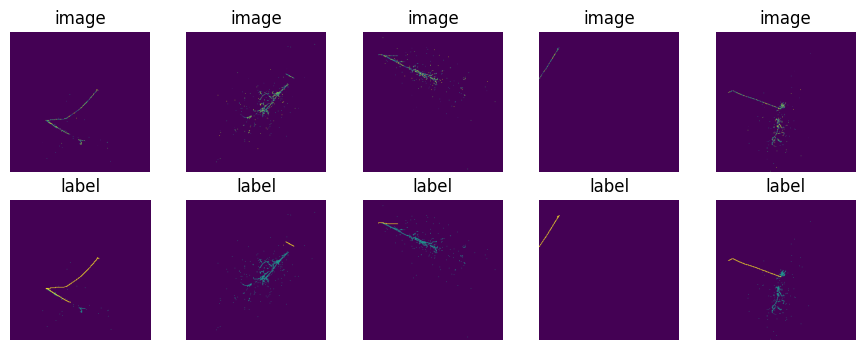

In [5]:
fig, axes = plt.subplots(2, 5, figsize = (11, 4))
for i in range(5):
    rnd_idx = np.random.choice(len(x_train), 1)[0]
    axes[0][i].imshow(x_train[rnd_idx].reshape(256, 256))
    axes[0][i].set_title('image')
    axes[0][i].axis('off')
    axes[1][i].imshow(y_train[rnd_idx].reshape(256, 256))
    axes[1][i].set_title('label')
    axes[1][i].axis('off')



---

# 2. Build the network

We use U-Net Xception-style model following [Keras official document](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
inputs = tf.keras.Input(shape=(256, 256, 1))

### [First half of the network: downsampling inputs] ###

# Entry block
x = Conv2D(32, 3, strides=2, padding="same")(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)

previous_block_activation = x  # Set aside residual

# Blocks 1, 2, 3 are identical apart from the feature depth.
for filters in [64, 128, 256]:
    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

for filters in [256, 128, 64, 32]:
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(2)(x)

    # Project residual
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding="same")(residual)
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

# Add a per-pixel classification layer
outputs = Conv2D(3, 3, activation="softmax", padding="same")(x)

# Define the model
model = tf.keras.Model(inputs, outputs)

model.summary()
```
    
</p>
</details>

In [6]:
inputs = tf.keras.Input(shape=(256, 256, 1))

### [First half of the network: downsampling inputs] ###

# Entry block
x = Conv2D(32, 3, strides=2, padding="same")(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)

previous_block_activation = x  # Set aside residual

# Blocks 1, 2, 3 are identical apart from the feature depth.
for filters in [64, 128, 256]:
    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

for filters in [256, 128, 64, 32]:
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(2)(x)

    # Project residual
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding="same")(residual)
    x = keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

# Add a per-pixel classification layer
outputs = Conv2D(3, 3, activation="softmax", padding="same")(x)

# Define the model
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 128,  │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 128, 128,  │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 64, 64,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 2,058,403 (7.85 MB)

 Trainable params: 2,054,627 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

### Compile and train the model

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy())

# train the model
training_history = model.fit(x_train, y_train, epochs=10, batch_size=32)
```
    
</p>
</details>

In [7]:
# optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy())

# train the model
training_history = model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 698ms/step - loss: 1.5308
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 246ms/step - loss: 0.0582
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - loss: 0.0365
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - loss: 0.0327
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - loss: 0.0299
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - loss: 0.0283
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - loss: 0.0274
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - loss: 0.0268
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - loss: 0.0262
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - loss: 0.0256


---

# 3. Analyse results

### Check training history

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
plt.figure
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

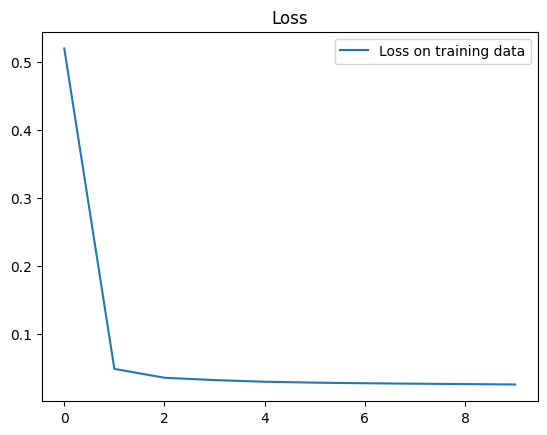

In [8]:
plt.figure
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.legend()
plt.title("Loss")
plt.show()

### Make predictions

In [9]:
# use a batch of test images to predict
batch = x_test[:32]
pred_labels = model.predict(batch).argmax(axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


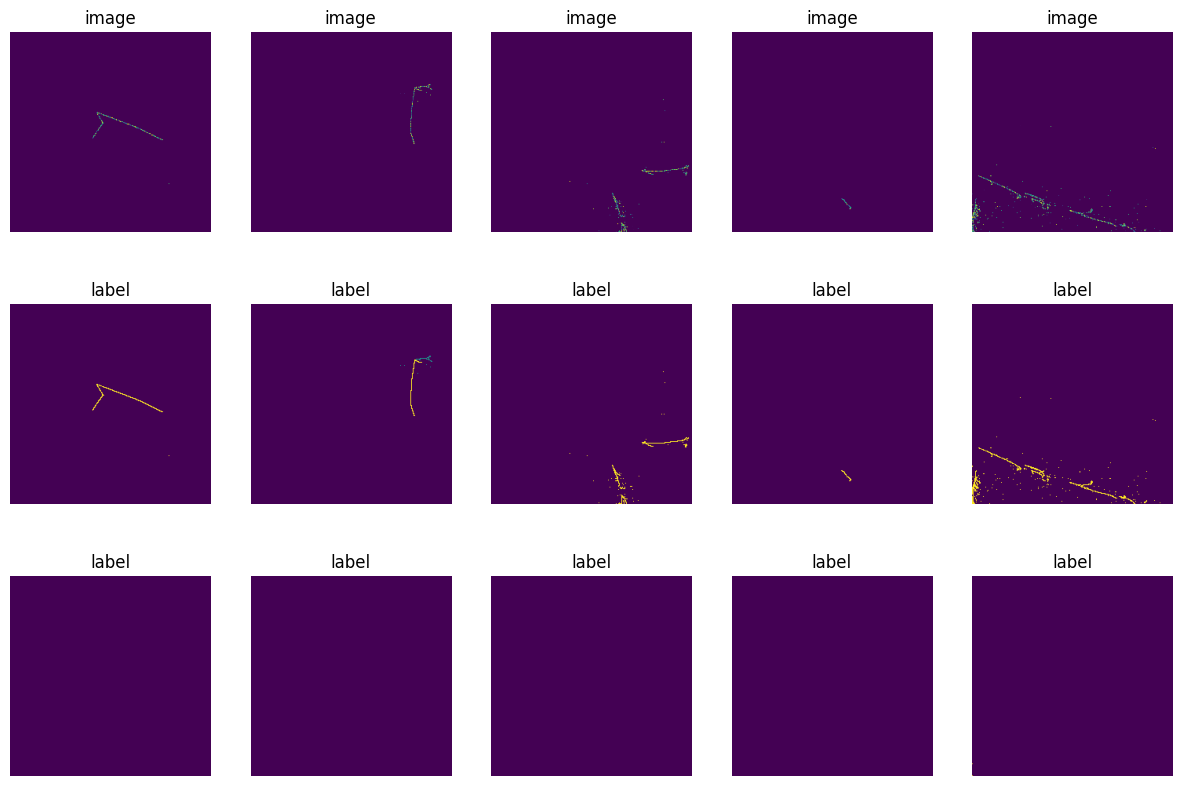

In [10]:
fig, axes = plt.subplots(3, 5, figsize = (15, 10))
for i in range(5):
    rnd_idx = np.random.choice(len(batch), 1)[0]
    axes[0][i].imshow(x_test[rnd_idx].reshape(256, 256))
    axes[0][i].set_title('image')
    axes[0][i].axis('off')
    axes[1][i].imshow(y_test[rnd_idx].reshape(256, 256))
    axes[1][i].set_title('label')
    axes[1][i].axis('off')
    axes[2][i].imshow(pred_labels[rnd_idx].reshape(256, 256))
    axes[2][i].set_title('label')
    axes[2][i].axis('off')

---

# 4.Exercises

Think segmentation as a classification task on pixel level. In this case, the number of background is much greater than the number of EM-shower particles and track particles, which causes label imbalance.

* Add more convolutional layers
* Weight EM-shower particles and track particles labels